In [1]:
# IMPORTING MODULES:
import os
import pandas as pd
import pickle 
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error

#@ IGNORING WARNINGS: 
import warnings
warnings.filterwarnings("ignore")

In [4]:
# IMPORTING AND SETTING UP MLFLOW:
import mlflow
mlflow.set_tracking_uri("sqlite:///mlflow.db")
mlflow.set_experiment("nyc-taxi-exp")

2022/05/28 15:30:00 INFO mlflow.tracking.fluent: Experiment with name 'nyc-taxi-exp' does not exist. Creating a new experiment.


<Experiment: artifact_location='./mlruns/2', experiment_id='2', lifecycle_stage='active', name='nyc-taxi-exp', tags={}>

In [6]:
# DOWNLOADING THE DATASET: UNCOMMENT BELOW:
# !wget https://s3.amazonaws.com/nyc-tlc/trip+data/green_tripdata_2021-01.parquet
# !wget https://s3.amazonaws.com/nyc-tlc/trip+data/green_tripdata_2021-02.parquet

In [8]:
# READING THE DATASET:
df = pd.read_parquet("./data/green_tripdata_2021-01.parquet")    # Reading dataset.
df.head()                                                   # Inspection.

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge
0,2,2021-01-01 00:15:56,2021-01-01 00:19:52,N,1.0,43,151,1.0,1.01,5.5,0.5,0.5,0.00,0.0,NaN,0.3,6.80,2.0,1.0,0.00
1,2,2021-01-01 00:25:59,2021-01-01 00:34:44,N,1.0,166,239,1.0,2.53,10.0,0.5,0.5,2.81,0.0,NaN,0.3,16.86,1.0,1.0,2.75
2,2,2021-01-01 00:45:57,2021-01-01 00:51:55,N,1.0,41,42,1.0,1.12,6.0,0.5,0.5,1.00,0.0,NaN,0.3,8.30,1.0,1.0,0.00
3,2,2020-12-31 23:57:51,2021-01-01 00:04:56,N,1.0,168,75,1.0,1.99,8.0,0.5,0.5,0.00,0.0,NaN,0.3,9.30,2.0,1.0,0.00
4,2,2021-01-01 00:16:36,2021-01-01 00:16:40,N,2.0,265,265,3.0,0.00,-52.0,0.0,-0.5,0.00,0.0,NaN,-0.3,-52.80,3.0,1.0,0.00


In [9]:
# PROCESSING THE DATASET:
df["duration"] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
df.duration = df.duration.apply(lambda x: x.total_seconds() / 60)
df = df[(df.duration >= 1) & (df.duration <= 60)]
df.head()

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,...,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge,duration
0,2,2021-01-01 00:15:56,2021-01-01 00:19:52,N,1.0,43,151,1.0,1.01,5.5,...,0.5,0.00,0.0,NaN,0.3,6.80,2.0,1.0,0.00,3.933333
1,2,2021-01-01 00:25:59,2021-01-01 00:34:44,N,1.0,166,239,1.0,2.53,10.0,...,0.5,2.81,0.0,NaN,0.3,16.86,1.0,1.0,2.75,8.750000
2,2,2021-01-01 00:45:57,2021-01-01 00:51:55,N,1.0,41,42,1.0,1.12,6.0,...,0.5,1.00,0.0,NaN,0.3,8.30,1.0,1.0,0.00,5.966667
3,2,2020-12-31 23:57:51,2021-01-01 00:04:56,N,1.0,168,75,1.0,1.99,8.0,...,0.5,0.00,0.0,NaN,0.3,9.30,2.0,1.0,0.00,7.083333
7,2,2021-01-01 00:26:31,2021-01-01 00:28:50,N,1.0,75,75,6.0,0.45,3.5,...,0.5,0.96,0.0,NaN,0.3,5.76,1.0,1.0,0.00,2.316667


In [10]:
# INSPECTING DATAFRAME:
df.dtypes

VendorID                          int64
lpep_pickup_datetime     datetime64[ns]
lpep_dropoff_datetime    datetime64[ns]
store_and_fwd_flag               object
RatecodeID                      float64
PULocationID                      int64
DOLocationID                      int64
passenger_count                 float64
trip_distance                   float64
fare_amount                     float64
extra                           float64
mta_tax                         float64
tip_amount                      float64
tolls_amount                    float64
ehail_fee                       float64
improvement_surcharge           float64
total_amount                    float64
payment_type                    float64
trip_type                       float64
congestion_surcharge            float64
duration                        float64
dtype: object

In [11]:
# PROCESSING THE DATASET:
categorical = ['PULocationID', 'DOLocationID']
numerical = ['trip_distance']
df[categorical] = df[categorical].astype(str)       # Conversion. 
df.dtypes                                           # Inspection.

VendorID                          int64
lpep_pickup_datetime     datetime64[ns]
lpep_dropoff_datetime    datetime64[ns]
store_and_fwd_flag               object
RatecodeID                      float64
PULocationID                     object
DOLocationID                     object
passenger_count                 float64
trip_distance                   float64
fare_amount                     float64
extra                           float64
mta_tax                         float64
tip_amount                      float64
tolls_amount                    float64
ehail_fee                       float64
improvement_surcharge           float64
total_amount                    float64
payment_type                    float64
trip_type                       float64
congestion_surcharge            float64
duration                        float64
dtype: object

In [12]:
# INITIALIZING ONE HOT ENCODING:
train_dicts = df[categorical + numerical].to_dict(orient="records")     # Initializing dictionary. 
dv = DictVectorizer()                                                   # Initializing dict vectorizer.
X_train = dv.fit_transform(train_dicts)                                 # Initializing one hot encoding.
target = "duration"
y_train = df[target].values                                             # Initialization.

In [13]:
# TRAINING LINEAR REGRESSION:
lr = LinearRegression()                                 # Initialization.
lr.fit(X_train, y_train)                                # Training the LR model.
y_pred = lr.predict(X_train)                            # Initializing prediction.
mean_squared_error(y_train, y_pred, squared=False)      # Inspecting MSE.

9.838799799829477

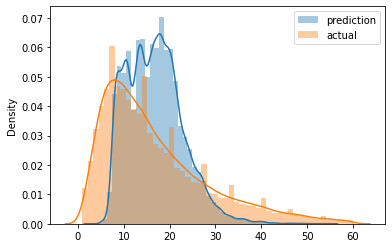

In [14]:
# VISUALIZATION OF PREDICTION:
sns.distplot(y_pred, label="prediction")
sns.distplot(y_train, label="actual")
plt.legend();

In [15]:
# OVERALL FUNCTION TO PREPARE DATAFRAME:
def read_dataframe(filename):                                                           # Defining function.
    if filename.endswith(".csv"):                                                       # Checking.
        df = pd.read_csv(filename)                                                      # Reading the dataset.
        df.lpep_dropoff_datetime = pd.to_datetime(df.lpep_dropoff_datetime)             # Converting to datetime. 
        df.lpep_pickup_datetime = pd.to_datetime(df.lpep_pickup_datetime)               # Converting to datetime. 
    elif filename.endswith(".parquet"):
        df = pd.read_parquet(filename)
    df["duration"] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
    df.duration = df.duration.apply(lambda x: x.total_seconds() / 60)
    df = df[(df.duration >= 1) & (df.duration <= 60)]
    categorical = ['PULocationID', 'DOLocationID']
    numerical = ['trip_distance']
    df[categorical] = df[categorical].astype(str)                                       # Conversion.
    return df

In [17]:
# INITIALIZING DATAFRAME:
df_train = read_dataframe("./data/green_tripdata_2021-01.parquet")           # Training dataframe.
df_val = read_dataframe("./data/green_tripdata_2021-02.parquet")             # Validation dataframe.
len(df_train), len(df_val)                                              # Inspection.

(73908, 61921)

In [18]:
# PROCESSING THE DATA:
df_train["PU_DO"] = df_train['PULocationID'] + '_' + df_train['DOLocationID']
df_val["PU_DO"] = df_val["PULocationID"] + "_" + df_val["DOLocationID"]
df_train.head()

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,...,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge,duration,PU_DO
0,2,2021-01-01 00:15:56,2021-01-01 00:19:52,N,1.0,43,151,1.0,1.01,5.5,...,0.00,0.0,NaN,0.3,6.80,2.0,1.0,0.00,3.933333,43_151
1,2,2021-01-01 00:25:59,2021-01-01 00:34:44,N,1.0,166,239,1.0,2.53,10.0,...,2.81,0.0,NaN,0.3,16.86,1.0,1.0,2.75,8.750000,166_239
2,2,2021-01-01 00:45:57,2021-01-01 00:51:55,N,1.0,41,42,1.0,1.12,6.0,...,1.00,0.0,NaN,0.3,8.30,1.0,1.0,0.00,5.966667,41_42
3,2,2020-12-31 23:57:51,2021-01-01 00:04:56,N,1.0,168,75,1.0,1.99,8.0,...,0.00,0.0,NaN,0.3,9.30,2.0,1.0,0.00,7.083333,168_75
7,2,2021-01-01 00:26:31,2021-01-01 00:28:50,N,1.0,75,75,6.0,0.45,3.5,...,0.96,0.0,NaN,0.3,5.76,1.0,1.0,0.00,2.316667,75_75


In [19]:
# INITIALIZING ONE HOT ENCODING:
categorical = ["PU_DO"]
numerical = ["trip_distance"] 
dv = DictVectorizer()                                                       # Initializing dict vectorizer.
train_dicts = df_train[categorical + numerical].to_dict(orient="records")   # Initializing dictionary.
X_train = dv.fit_transform(train_dicts)                                     # Initializing one hot encoding.
val_dicts = df_val[categorical + numerical].to_dict(orient="records")       # Initializing dictionary.
X_val = dv.transform(val_dicts)                                           # Initializing one hot encoding.
target = "duration"
y_train = df_train[target].values                                           # Initialization.
y_val = df_val[target].values

In [32]:
# TRAINING LINEAR REGRESSION:
lr = LinearRegression()                                 # Initialization.
lr.fit(X_train, y_train)                                # Training the LR model.
y_pred = lr.predict(X_val)                              # Initializing prediction.
mean_squared_error(y_val, y_pred, squared=False)        # Inspecting MSE.

7.4795869498500265

In [21]:
# SAVING THE MODEL:
with open("models/lin_reg.bin", "wb") as f_out:
    pickle.dump((dv, lr), f_out)

In [23]:
# TRAINING LASSO REGRESSION: TRACKING USING MLFLOW:
with mlflow.start_run():
    mlflow.set_tag("developer", "thinam")                   # Tracking the modifications.
    
    mlflow.log_param("train-data-path", "./data/green_tripdata_2021-01.parquet")
    mlflow.log_param("val-data-path", "./data/green_tripdata_2021-02.parquet")
    
    alpha = 0.01
    mlflow.log_param("alpha", alpha)
    
    lr = Lasso(alpha)                                       # Initialization.
    lr.fit(X_train, y_train)                                # Training the LASSO model.
    
    y_pred = lr.predict(X_val)                              # Initializing prediction.
    rmse = mean_squared_error(y_val, y_pred, squared=False) # Inspecting MSE.
    mlflow.log_metric("rmse", rmse)